## Reading mitab data from psicquic
* [Requests API](https://requests.readthedocs.io/en/master/)

In [1]:
proxies = {
  'http': 'http://ftprox.ibcp.fr:3128',
  'https': 'http://ftprox.ibcp.fr:3128',
}
proxies = {}

# Recuperer les donnes MITAB de Calderwood et al.

In [2]:
import requests

psicquicProviderURL="http://www.ebi.ac.uk/Tools/webservices/psicquic/intact/webservices/current/search"
miqlMethod="query"
miqlField="pubid"
miqlValue="17446270"

miqlRequest= f"{psicquicProviderURL}/{miqlMethod}/{miqlField}:{miqlValue}"

print(miqlRequest)

try:
    httpReq = requests.get(miqlRequest, proxies=proxies)
except NameError:
    httpReq = requests.get(miqlRequest)

ans = httpReq.text

http://www.ebi.ac.uk/Tools/webservices/psicquic/intact/webservices/current/search/query/pubid:17446270


In [34]:
import re

def mitabReader(httpText):
    for line in ans.split("\n"):
        _ = line.split("\t")
        if len(_) > 1 and _[0].startswith("uniprotkb:")\
                      and _[1].startswith("uniprotkb:"):
            yield [ _[0].replace("uniprotkb:", ""),\
                    _[1].replace("uniprotkb:", "") ]\
                  + _[2:]
                
            
def isMitab_EBV_EBV(mitabArray):
    reEBV   = "taxid:(1037[6-7]|82830)"
    if re.search(reEBV, mitabArray[9]) and re.search(reEBV, mitabArray[10]):
        return True
    return False

def isMitab_Human_EBV(mitabLine):
    reHuman = "taxid:9606"
    reEBV   = "taxid:(1037[6-7]|82830)"
    if re.search(reEBV, mitabArray[9]) and re.search(reHuman, mitabArray[10]) or\
       re.search(reHuman, mitabArray[9]) and re.search(reEBV, mitabArray[10]):
        return True
    return False


EBV_EBV_mitab   = []
EBV_Human_mitab = []
total = 0
for mitabArray in mitabReader(ans):
    total += 1
    if isMitab_EBV_EBV(mitabArray):
        EBV_EBV_mitab.append(mitabArray)
    elif isMitab_Human_EBV(mitabArray):
        EBV_Human_mitab.append(mitabArray)
    else : 
        raise ValueError("Je ne connais pas cette espece ==> ", mitabArray[9:11])

print(len(EBV_EBV_mitab))
print(len(EBV_Human_mitab))
print(f"Nombre total d'interactions {total}, EBV-EBV {len(EBV_EBV_mitab)}")

59
171
Nombre total d'itneractions 230, EBV-EBV 59


### Graph EBV-EBV

In [36]:
import networkx as nx
import re

G_EBV = nx.Graph()

for psqDatum in EBV_EBV_mitab:
    G_EBV.add_edge(psqDatum[0], psqDatum[1])

### Draw EBV-EBV PPI network
* Labeled with uniprotID
* [NetworkX Draw](https://networkx.github.io/documentation/latest/reference/generated/networkx.drawing.nx_pylab.draw_networkx.html#networkx.drawing.nx_pylab.draw_networkx)

In [40]:
%matplotlib inline
import matplotlib.pyplot as plt

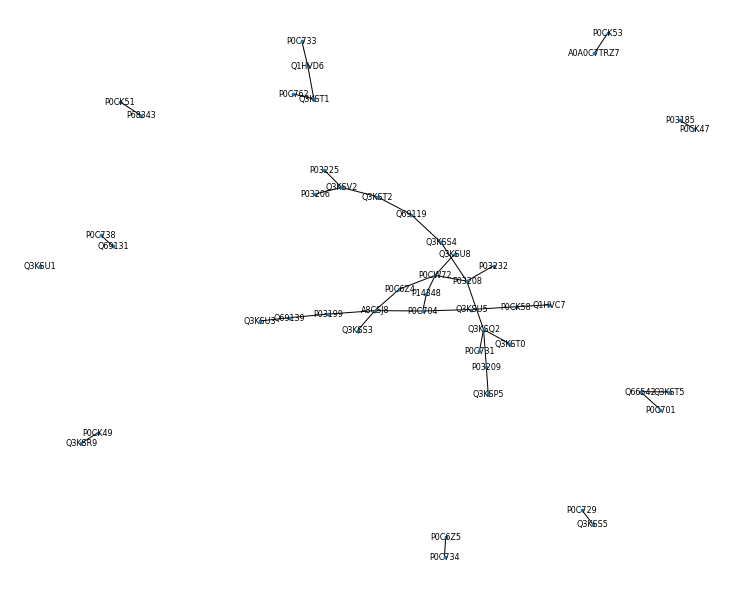

In [61]:
plt.figure(figsize=(10, 8))
nx.draw(G_EBV, with_labels=True, node_size=3, font_size=8, linewidths=2)
plt.show()

#### Draw EBV-EBV PPI network
* Labeled with gene Name
* Information provider: `./data/Calderwood_EBV_proteome.xml`
* [NetworkX Draw](https://networkx.github.io/documentation/latest/reference/generated/networkx.drawing.nx_pylab.draw_networkx.html#networkx.drawing.nx_pylab.draw_networkx)

In [42]:
from xml.etree.ElementTree import parse, dump, fromstring, register_namespace, ElementTree

# Utility functions

def goTerms(xmlEntry):
    ns = '{http://uniprot.org/uniprot}'
    goTerms = xmlEntry.findall(ns +'dbReference[@type="GO"]')
    goTermList = []
    for goT in goTerms:
        gID   = goT.attrib['id']
        gName = goT.find(ns +'property[@type="term"]').attrib['value']
        goTermList.append({"name" : gName, "ID" : gID})
    return goTermList

def proteinDict(uniprotID, root):
    ns   = '{http://uniprot.org/uniprot}' 
    data = { "accession" : uniprotID, "geneName" : None, "name" : None,
             "GOterms" : None
           }
    for entry in root.findall(ns+'entry'):
        accessions = entry.findall(ns+"accession")
        for acc in accessions:
            if acc.text == uniprotID:
                e = entry.find(f"{ns}protein/{ns}recommendedName/{ns}fullName")
                if not e is None:
                    data["name"] = e.text 
                e = entry.find(f"{ns}gene/{ns}name")
                if not e is None:
                    data["geneName"] = e.text         

                data["GOterms"] = goTerms(entry)
                return data
    raise ValueError(uniprotID)
# Test
tree = parse('./data/Calderwood_Human_proteome.xml')
root = tree.getroot()    
proteinDict("Q53Y88", root)

{'accession': 'Q53Y88',
 'geneName': 'GRN',
 'name': 'Progranulin',
 'GOterms': [{'name': 'C:azurophil granule lumen', 'ID': 'GO:0035578'},
  {'name': 'C:endoplasmic reticulum', 'ID': 'GO:0005783'},
  {'name': 'C:endosome', 'ID': 'GO:0005768'},
  {'name': 'C:extracellular exosome', 'ID': 'GO:0070062'},
  {'name': 'C:extracellular region', 'ID': 'GO:0005576'},
  {'name': 'C:extracellular space', 'ID': 'GO:0005615'},
  {'name': 'C:Golgi apparatus', 'ID': 'GO:0005794'},
  {'name': 'C:late endosome', 'ID': 'GO:0005770'},
  {'name': 'C:lysosomal membrane', 'ID': 'GO:0005765'},
  {'name': 'C:lysosome', 'ID': 'GO:0005764'},
  {'name': 'C:membrane', 'ID': 'GO:0016020'},
  {'name': 'C:plasma membrane', 'ID': 'GO:0005886'},
  {'name': 'C:trans-Golgi network', 'ID': 'GO:0005802'},
  {'name': 'F:chaperone binding', 'ID': 'GO:0051087'},
  {'name': 'F:cytokine activity', 'ID': 'GO:0005125'},
  {'name': 'F:growth factor activity', 'ID': 'GO:0008083'},
  {'name': 'F:RNA binding', 'ID': 'GO:0003723'},


#### Create a dict to map default uniprotID with gene name, we keep uniprotID if gene name is missing

In [ ]:
tree = parse('./data/Calderwood_EBV_proteome.xml')
root = tree.getroot()    

EBV_EBV_geneLabels = {}
for node in G_EBV.nodes():
    pDict = proteinDict(node, root)
    EBV_EBV_geneLabels[node] =  pDict["geneName"] if pDict["geneName"] else str(node)
EBV_EBV_geneLabels

##### Draw EBV network with gene labels

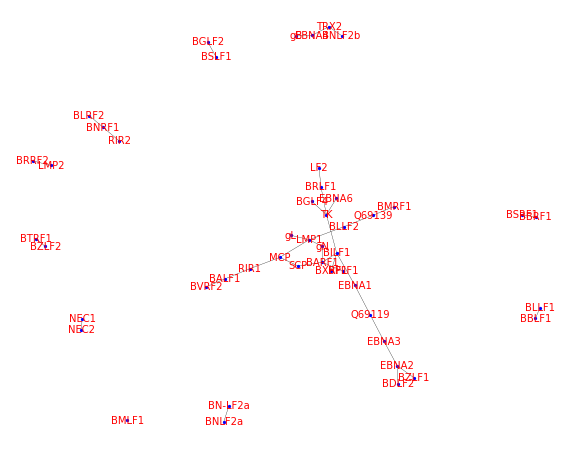

In [51]:
plt.figure(figsize=(10, 8))
plt.axis('off')

#pos=nx.draw(G, with_labels=False)
pos=nx.spring_layout(G_EBV)

nx.draw_networkx_nodes(G_EBV, pos, node_size=5, node_color="blue")
nx.draw_networkx_labels(G_EBV,pos,EBV_EBV_geneLabels,font_size=10,font_weight=400,font_color='r')
nx.draw_networkx_edges(G_EBV, pos, width=0.3)

plt.show()

### Draw the EBV-human interactome w/ label only on human genes
* Node labeled with gene Name
* Different symbols for human and EBV genes respectively
* Spring layout
* [Bipartite layout](https://networkx.github.io/documentation/stable/reference/algorithms/bipartite.html?highlight=bipartite#module-networkx.algorithms.bipartite)

In [55]:
G2 = nx.Graph()
humanGeneLabels = {}
ebvGeneLabels   = {}

for psqDatum in EBV_Human_mitab:
    #print(psqDatum)
    (a, b) = ( psqDatum[0], psqDatum[1] )
    G2.add_edge(a, b)
    (a,b) = (a,b) if re.search(reHuman, psqDatum[9]) else (b,a)
    humanGeneLabels[a] = None
    ebvGeneLabels[b]   = None
    
tree = parse('./data/Calderwood_Human_proteome.xml')
root = tree.getroot()    
for humanID in humanGeneLabels.keys():
    pDict = proteinDict(humanID, root)
    humanGeneLabels[humanID] = pDict["geneName"] if pDict["geneName"] else humanID
    
tree = parse('./data/Calderwood_EBV_proteome.xml')
root = tree.getroot()    
for ebvID in ebvGeneLabels.keys():
    pDict = proteinDict(ebvID, root)
    ebvGeneLabels[ebvID] = pDict["geneName"] if pDict["geneName"] else ebvID


##### Using a Spring layout, we draw nodes separately for EBV and human

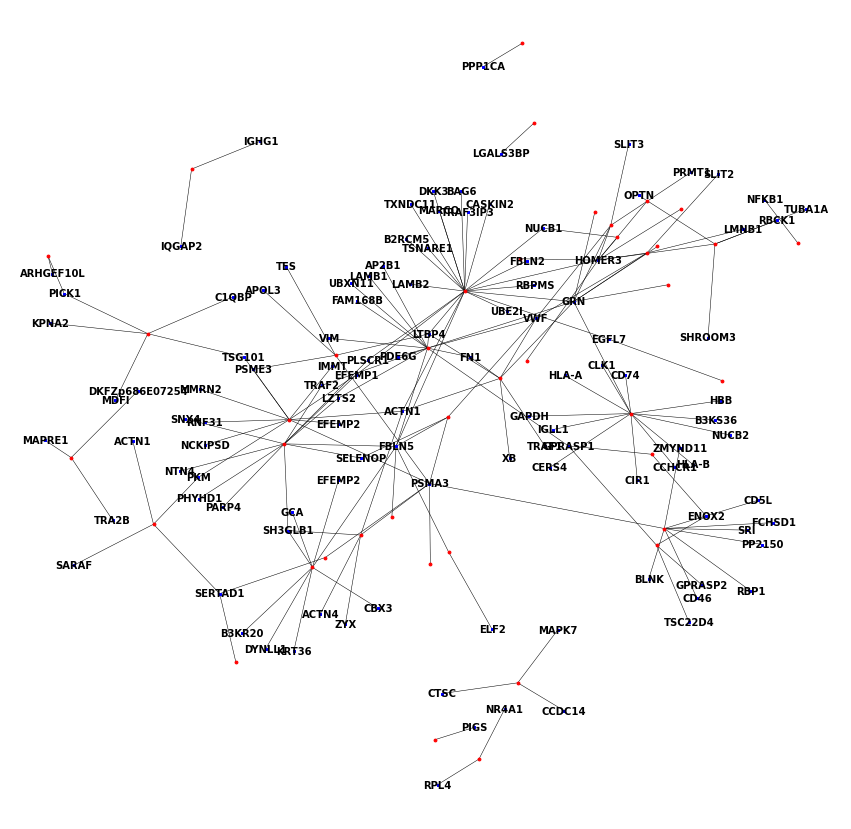

In [58]:
plt.figure(figsize=(15, 15))
plt.axis('off')

#pos=nx.draw(G, with_labels=False)
pos=nx.spring_layout(G2, k= 0.225)

nx.draw_networkx_nodes(G2, pos, node_size=8, node_color="blue", node_shape="s",nodelist=humanGeneLabels.keys() )
nx.draw_networkx_nodes(G2, pos, node_size=8, node_color="red", node_shape="o",nodelist=ebvGeneLabels.keys() )
nx.draw_networkx_labels(G2,pos,humanGeneLabels,font_size=10,font_weight=800,font_color='black')
nx.draw_networkx_edges(G2, pos, width=0.5)
#plt.savefig("human_ebv.png")
plt.show()

[Bipartite](https://networkx.github.io/documentation/stable/reference/generated/networkx.drawing.layout.bipartite_layout.html)

* Iterateur G.nodes()
* Table de nom de noeuds humains
* Table de noms de noeuds ebv
* Bipartition d'un graph en specifiant seulemnt les label d'une partition.

```python
import networkx as nx
plt.figure()
plt.axis('off')

G = nx.Graph()
G.add_edge("A", "C")
G.add_edge("B", "C")
X, Y = nx.bipartite.sets(G,  ["A", "B"])
pos = nx.bipartite_layout(G, X)
nx.draw_networkx_nodes(G, pos, node_color="blue", node_shape="o",nodelist=["A", "B"] )
nx.draw_networkx_nodes(G, pos, node_color="red", node_shape="o",nodelist=["C"] )
nx.draw_networkx_labels(G,pos,font_weight=800,font_color='black')
nx.draw_networkx_edges(G, pos, width=0.5)
```

In [ ]:
import networkx as nx
plt.figure()
plt.axis('off')

G = nx.Graph()
G.add_edge("A", "C")
G.add_edge("B", "C")
X, Y = nx.bipartite.sets(G,  ["A", "B"])
pos = nx.bipartite_layout(G, X)
nx.draw_networkx_nodes(G, pos, node_color="blue", node_shape="o",nodelist=["A", "B"] )
nx.draw_networkx_nodes(G, pos, node_color="red", node_shape="o",nodelist=["C"] )
nx.draw_networkx_labels(G,pos,font_weight=800,font_color='black')
nx.draw_networkx_edges(G, pos, width=0.5)


In [ ]:
plt.figure(figsize=(10, 10))
plt.axis('off')

X, Y = nx.bipartite.sets(G2, humanGeneLabels.keys())
pos = nx.bipartite_layout(G2, X)

allGeneLabels = {}
allGeneLabels.update(humanGeneLabels)
allGeneLabels.update(ebvGeneLabels)

nx.draw_networkx_nodes(G2, pos, node_size=8, node_color="blue", node_shape="s",nodelist=humanGeneLabels.keys() )
nx.draw_networkx_nodes(G2, pos, node_size=8, node_color="red", node_shape="o",nodelist=ebvGeneLabels.keys() )
nx.draw_networkx_labels(G2,pos,allGeneLabels,font_size=6,font_weight=800,font_color='black')
nx.draw_networkx_edges(G2, pos, width=0.5)

### Multiple histogram of protein degree
* Human-Human: complete mitab data, Graph already built
* EBV-Human: interactant pair data, Graph to build

In [ ]:
human_file = "data/human_interactome_pair_uniprot.tab"

G_human = nx.Graph()
with open(human_file, "r") as fp:
    for l in fp:
        _ = l.rstrip().split()
        if _:
            G_human.add_edge(_[0], _[1])
            
degHuman = { str(x) : G_human.degree(x) for x in G_human.nodes }

degHuman_EBV_target = { humanID : degHuman[humanID] for humanID in humanGeneLabels.keys() if humanID in degHuman }

In [ ]:
print(f"Total human EBV target {len(humanGeneLabels)}, Total with degree info {len(degHuman_EBV_target)}")

In [ ]:
from scipy import stats

all_data = [  np.array([ v for k, v in degHuman_EBV_target.items() ]),
              np.array([ v for k, v in degHuman.items() ])
           ]


fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 5))
ax.hist( [ all_data[0], all_data[1] ],
         label=['Human-EBV', 'Human-self'], 
         density=True, bins=50 )
fig.legend(loc='upper right')
fig.suptitle("Normalized Node Degree Distribution")
fig.show()

print(f"Human-EBV statistics {stats.describe(all_data[0])}")
print(f"Human-Human statistics {stats.describe(all_data[1])}")

In [ ]:
# Random test data
import numpy as np
labels = ['EBV target', 'All Human']

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9, 4))

all_data = [  np.array([ v for k, v in degHuman_EBV_target.items() ]),
              np.array([ v for k, v in degHuman.items() ])]#,
#              np.array([ v for k, v in degEcoli.items() ]),
           

#all_data = [ np.true_divide(v, len(v)) for v in all_data ] 

# rectangular box plot
bplot1 = ax.violinplot(all_data
                     )  # will be used to label x-ticks

def set_axis_style(ax, labels):
    ax.get_xaxis().set_tick_params(direction='out')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xticks(np.arange(1, len(labels) + 1))
    ax.set_xticklabels(labels)
    ax.set_xlim(0.25, len(labels) + 0.75)
    ax.set_xlabel('Sample name')
    
set_axis_style(ax, labels)

In [ ]:
# Random test data

labels = ['EBV target', 'All Human', 'E.Coli']

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))

all_data = [  [ v for k, v in degHuman_EBV_target.items() ],
              [ v for k, v in degHuman.items() ],
              [ v for k, v in degEcoli.items() ],
           ]

# rectangular box plot
bplot1 = ax1.boxplot(all_data,
                     vert=True,  # vertical box alignment
                     patch_artist=True,  # fill with color
                     labels=labels)  # will be used to label x-ticks
ax1.set_title('Rectangular box plot')

# notch shape box plot
bplot2 = ax2.boxplot(all_data,
                     notch=True,  # notch shape
                     vert=True,  # vertical box alignment
                     patch_artist=True,  # fill with color
                     labels=labels)  # will be used to label x-ticks
ax2.set_title('Notched box plot')

# fill with colors
colors = ['pink', 'lightblue', 'lightgreen']
for bplot in (bplot1, bplot2):
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)

# adding horizontal grid lines
for ax in [ax1, ax2]:
    ax.yaxis.grid(True)
    ax.set_xlabel('Three separate samples')
    ax.set_ylabel('Observed values')

### Display some interactivity

In [ ]:
import json

nodes = [{'name': str(i),
          'id': humanGeneLabels[i] if i in humanGeneLabels else ebvGeneLabels[i],
          'type' : 'Human' if i in humanGeneLabels.keys() else 'EBV',
          'weight':G2.degree(i)
         }
         for i in G2.nodes()
        ]

links = []
for a,b in G2.edges() :
   # print(a,b)
    _ = { "source" : None, "target" : None }
    
    for i, n in enumerate(nodes):
        if n['name'] == a:
            _["source"] = i
        elif n['name'] == b:
            _["target"] = i
    if  _["source"] is None or _["target"] is None:
        print(_)
        raise ValueError(a,b)
    
    links.append(_)
         
with open('graph.json', 'w') as f:
    json.dump({'nodes': nodes, 'links': links},
              f, indent=4)
    

In [ ]:
%%html
<div id="d3-example"></div>
Graph EBV Human
<style>
.node {stroke: #fff; stroke-width: 1.5px;}
.link {stroke: #999; stroke-opacity: .6;}
</style>

In [ ]:
%%javascript
//const d3path = "https://d3js.org/d3.v6.min.js"
const d3path = "d3.v6.min.js"
 console.log("Starting");
// We load the d3.js library from the Web.
require.config( { paths : { d3: d3path }
    } );

require(["d3"], function(d3) {
    console.log("Loading");
  // The code in this block is executed when the
  // d3.js library has been loaded.

  // First, we specify the size of the canvas
  // containing the visualization (size of the
  // <div> element).
  var width = 800, height = 800;

  // We create a color scale.
  var color = d3.scale.category10();

  // Create scale for node radius
  let rMin = 3, rMax = 12;
  let degMin = 1, degMax = 0;

    
  // We create a force-directed dynamic graph layout.
  var force = d3.layout.force()
    .charge(-120)
    .linkDistance(30)
    .size([width, height]);

  // In the <div> element, we create a <svg> graphic
  // that will contain our interactive visualization.
  var svg = d3.select("#d3-example").select("svg")
  if (svg.empty()) {
    svg = d3.select("#d3-example").append("svg")
          .attr("width", width)
          .attr("height", height);
  }

  // We load the JSON file.
  d3.json("graph.json", function(error, graph) {
    // In this block, the file has been loaded
    // and the 'graph' object contains our graph.
    console.log("Loading JSON")
    // We load the nodes and links in the
    // force-directed graph.
    console.dir(graph);
    force.nodes(graph.nodes);
    console.log("nodes loaded");
    force.links(graph.links)
    console.log("links loaded");
   
    // We create a <line> SVG element for each link
    // in the graph.
    var link = svg.selectAll(".link")
      .data(graph.links)
      .enter().append("line")
      .attr("class", "link");

    // We create a <circle> SVG element for each node
    // in the graph, and we specify a few attributes.
    var node = svg.selectAll(".node")
      .data(graph.nodes)
      .enter().append("circle")
      .attr("class", "node")
      //.attr("r", 5)  // radius
      .style("fill", function(d) {
          return  d.type === "EBV" ? "firebrick" : "steelblue"
      }).each(function(d) {
          degMax = d.weight > degMax ? d.weight : degMax;
      })
      .call(force.drag);

      
      let rScale = d3.scale.linear()
          .domain([degMin, degMax]) // unit: km
          .range([rMin,rMax]); // unit: pixels
      node.attr("r", function(d) {
           return rScale(d.weight);
      });  // radius
      
    // The name of each node is the node number.
    node.append("title")
        .text(function(d) { return d.name; });

    // We bind the positions of the SVG elements
    // to the positions of the dynamic force-directed
    // graph, at each time step.
    force.on("tick", function() {
      link.attr("x1", function(d){return d.source.x})
          .attr("y1", function(d){return d.source.y})
          .attr("x2", function(d){return d.target.x})
          .attr("y2", function(d){return d.target.y});

      node.attr("cx", function(d){return d.x})
          .attr("cy", function(d){return d.y});
    });
      
    force.start();
    console.log("OK");
  });
},
function (err) {
    console.log("Could not load JS library " + err);
});

## Go term présents dans les protéines humaines les plus ciblées par EBV
* Classer les protéines par degré
* Lister leur termes GO
* Connaissant l'organisation de l'ontologie GO, quelles suggestions pour augmenter la qualité de l'analyse?
* Classer les termes GO par occurences dans la liste des protéines humaine 

In [ ]:
### Score human protein by degree w/ EBV Proteins
EBV_rankByDegree   = sorted([ n for n in G2.nodes() if not n in humanGeneLabels.keys() ],
                              key = lambda x:G2.degree(x), reverse = True
                           )
Human_rankByDegree = sorted([ n for n in G2.nodes() if n in humanGeneLabels.keys() ],
                              key = lambda x:G2.degree(x), reverse = True
                           )    

In [ ]:
tree = parse('./data/Calderwood_Human_proteome.xml')
root = tree.getroot()   
for humanID in Human_rankByDegree[:3]:
    print(proteinDict(humanID, root)["GOterms"])


In [ ]:
tree = parse('./data/Calderwood_Human_proteome.xml')
root = tree.getroot()  

GO_rankings = []
for humanID in Human_rankByDegree:
    pDict = proteinDict(humanID, root)
    for newGo in pDict["GOterms"]:
        new = True
        for go in GO_rankings:
            if go["ID"] == newGo["ID"]:
                go["count"] += 1
                new = False
            break
        if new:
            newGo["count"] = 1
            GO_rankings.append(newGo)

GO_rankings = sorted(GO_rankings, key=lambda x:x["count"], reverse=True)

In [ ]:
GO_rankings

In [ ]:
class degreeTable:
    def __init__(self, nodeList):
        self.data = nodeList
    def _repr_html_(self): 
        html = "<table><thead><th>Node</th><th>Degree</th></thead>" 
        return html + "<tbody><tr>" + "</tr><tr>".join(
            [ f"<td>{str(n)}</td><td>{G2.degree(n)}</td>" for n in self.data ]
        ) + '</tr></tbody></table>'

degreeTable(EBV_rankByDegree)

In [ ]:
degreeTable(Human_rankByDegree)

# XML data preparation steps
##### Generation of:
* EBV uniprot entries in `Calderwood_EBV_proteome.xml`
* Human uniprot entries in `Calderwood_Human_proteome.xml`

### Get EBV xml Entries
* extract uniprot ID from mitab
* fetch individual uniprot xml
* Collect them in a single `Calderwood_EBV_proteome.xml` file

In [ ]:
from xml.etree.ElementTree import parse, dump, fromstring, register_namespace, ElementTree


#Fetch Xml document from uniprot

EBV_entryName = []
for psqDatum in EBV_psqData:
    EBV_entryName += [ _.replace("uniprotkb:", "") for _ in psqDatum[:2] ]

print(f"{len(EBV_psqData)} EBV-only psq data found {len(set(EBV_entryName))} EBV entries")
for psqDatum in HumanEBV_psqData:
    if re.search(reEBV, psqDatum[9]):
        EBV_entryName.append( psqDatum[0].replace("uniprotkb:", "") )
    elif re.search(reEBV, psqDatum[10]):
        EBV_entryName.append( psqDatum[1].replace("uniprotkb:", "") )
    else :
        raise ValueError(psqDatum)
    
EBV_entryName = set(EBV_entryName)

print(f"{len(EBV_psqData)} EBV-only & {len(HumanEBV_psqData)} EBV-Human psq data found {len(EBV_entryName)} EBV entries")

xmlRawDoc = []
for uniprotID in EBV_entryName:
    xmlRequest=f"https://www.uniprot.org/uniprot/{uniprotID}.xml"
    try:
        httpReq = requests.get(xmlRequest, proxies=proxies)
    except NameError:
        httpReq = requests.get(xmlRequest)

    xmlRawDoc.append(httpReq.text)


In [ ]:
register_namespace('', "http://uniprot.org/uniprot")
ns = '{http://uniprot.org/uniprot}'
collectionHolder = '<?xml version="1.0" encoding="UTF-8"?>\n<uniprot xmlns="http://uniprot.org/uniprot" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:schemaLocation="http://uniprot.org/uniprot http://www.uniprot.org/support/docs/uniprot.xsd"></uniprot>'
collection = fromstring(collectionHolder)

for _ in xmlRawDoc:
    tree = fromstring(_)
    collection.append(tree.find(ns+"entry"))

    _= f"{ns}entry"
print( f"initial number of xml document {len(xmlRawDoc)} found {len( collection.findall(_))} uniprot entries")
tree = ElementTree(collection)
tree.write("./data/Calderwood_EBV_proteome.xml")

### Get Human xml Entries
* extract uniprot ID from mitab
* fetch individual uniprot xml
* Collect them in a single `Calderwood_Human_proteome.xml` file


In [ ]:
humanEntryName = []
for psqDatum in HumanEBV_psqData:   
    if re.search(reHuman, psqDatum[9]):
        humanEntryName.append( psqDatum[0].replace("uniprotkb:", "") if  psqDatum[0].startswith("uniprotkb:") else  psqDatum[2].replace("uniprotkb:", ""))
    elif re.search(reHuman, psqDatum[10]):
         humanEntryName.append( psqDatum[1].replace("uniprotkb:", "") if  psqDatum[1].startswith("uniprotkb:") else  psqDatum[3].replace("uniprotkb:", ""))
    else :
        raise ValueError(psqDatum)
    if humanEntryName[-1] == '-': # Two mappings to uniprot are incorrect, we would need to go through gene name to rescue them
        humanEntryName = humanEntryName[:-1]

humanEntryName = set(humanEntryName)

print(f"{len(HumanEBV_psqData)} EBV-Human psq data found {len(humanEntryName)} human entries")

xmlRawDoc = []
for uniprotID in humanEntryName:
    xmlRequest=f"https://www.uniprot.org/uniprot/{uniprotID}.xml"
    try:
        httpReq = requests.get(xmlRequest, proxies=proxies)
    except NameError:
        httpReq = requests.get(xmlRequest)

    xmlRawDoc.append(httpReq.text)


In [ ]:
register_namespace('', "http://uniprot.org/uniprot")
ns = '{http://uniprot.org/uniprot}'
collectionHolder = '<?xml version="1.0" encoding="UTF-8"?>\n<uniprot xmlns="http://uniprot.org/uniprot" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:schemaLocation="http://uniprot.org/uniprot http://www.uniprot.org/support/docs/uniprot.xsd"></uniprot>'
collection = fromstring(collectionHolder)

for _, n in zip(xmlRawDoc, humanEntryName):
#    print(n,"-->", _)
    tree = fromstring(_)
    collection.append(tree.find(ns+"entry"))

    _= f"{ns}entry"
print( f"initial number of xml document {len(xmlRawDoc)} found {len( collection.findall(_))} uniprot entries")
tree = ElementTree(collection)
tree.write("./data/Calderwood_Human_proteome.xml")